# Import Modules

In [1]:
import typing as tp
import matplotlib.pyplot as plt
import sys
import random as r
import numpy as np
from dataclasses import dataclass
from tqdm import trange
import pickle
import os
from functools import partial
import time
import math

import jax
from jax import (
    numpy as jnp,
    Array,
    random as jrand
)
import keras as nn
nn.mixed_precision.set_dtype_policy("mixed_bfloat16")
import torch.utils.data
import torchvision
try:
    from flash_attn_jax import flash_mha
    USE_FLASH_ATT = True
except:
    USE_FLASH_ATT = False


print("Python Version", sys.version)
print(f"Keras Version {nn.__version__} with {nn.backend.backend()} backend \tJax Version {jax.__version__}")
print("Jax backend device", jax.default_backend())
print("PyTorch version:", torch.__version__)

Python Version 3.11.9 (main, Apr  6 2024, 17:59:24) [GCC 11.4.0]
Keras Version 3.0.4 with jax backend 	Jax Version 0.4.31
Jax backend device gpu
PyTorch version: 2.3.0+cpu


# Dataset

In [2]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(), # (H, W, C)/(H, W) -> (C, H, W) AND [0, 255] -> [0.0, 1.0]
    torchvision.transforms.Normalize(mean=(0.5,), std=(0.5,), inplace=True) # [0.0, 1.0] -> [-1.0, 1.0]
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
valset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

NUM_CLASSES = 10

In [3]:
class DataLoader:
    def __init__(self, ds):
        self.ds = ds
        
    def iter_batches(self, batch_size):
        while True:
            self.dataset = torch.utils.data.DataLoader(
                dataset=self.ds,
                batch_size=batch_size,
                shuffle=True,
                pin_memory=True,
                drop_last=True
            )
            for X_batch, y_batch in self.dataset:
                yield X_batch.permute(0, 2, 3, 1).numpy(), y_batch.numpy() # (B, C, H, W), (B,) => (B, H, W, C), (B,)

# Config

In [4]:
@dataclass
class config:
    seed:int = 0

    # Diffusion Args
    var_range:tuple[int, int] = (1e-4, 2e-2)
    num_timesteps:int = 400

    # Vit Args
    patch_size:int = 2
    H:int = 28
    W:int = 28
    in_channels:int = 1
    out_channels:int = in_channels
    N:int = H*W//patch_size**2
    assert N*patch_size**2 == H*W
    
    # weight init Args
    linear_init:tp.Callable = nn.initializers.GlorotUniform(seed=seed+1) # also known as Xavier Uniform
    bias_init:tp.Callable = nn.initializers.Zeros()

    label_emb_init:tp.Callable = nn.initializers.RandomNormal(stddev=0.02, seed=seed+2)
    timestep_mlp_init:tp.Callable = nn.initializers.RandomNormal(stddev=0.02, seed=seed+3)

    adaLN_linear_bias_init:tp.Callable = nn.initializers.Zeros()
    final_layer_linear_bias_init:tp.Callable = nn.initializers.Zeros()

    # transformer Args
    d_model:int = 288
    num_heads:int = 6
    assert d_model % 2 == 0
    assert d_model % num_heads == 0
    num_layers:int = 6
    num_classes:int = NUM_CLASSES
    dropout_rate:float = 0.0
    use_flash_att:bool = USE_FLASH_ATT # Does it even speed up training?
    maxlen:int = N

    # Training Args
    cfg_dropout_rate:float = 0.0

    batch_size:int = 64
    num_steps:int = 20_000
    decay_steps:int = num_steps
    warmup_steps:int = 100
    max_lr:float = 1e-3
    min_lr:float = 0.0*max_lr
    no_decay:bool = False # keeping this True will increase the loss in between training
    beta1:float = 0.9
    beta2:float = 0.999
    clipnorm:float = None
    weight_decay:float = 0.0
    # ema:float = 0.999
    
    patience:int = 10
    num_grad_accumalation_steps:int = 1
    ckpt_freq:int = 600
    checkpoint_dir:str = "checkpoints"
    return_best_train_states:bool = True

os.makedirs(config.checkpoint_dir, exist_ok=True)

# Diffusion Utils

In [5]:
class DiffusionUtils:
    def __init__(self, config:config):
        self.num_timesteps = config.num_timesteps # (nT,)
        self.beta_range = config.var_range
        self.get_alpha()

        self.H, self.W = config.H, config.W
        self.in_channels = config.in_channels

    def get_alpha(self):
        self.beta = jnp.linspace(*self.beta_range, num=self.num_timesteps) # (nT,)
        self.alpha = 1-self.beta # (nT,)
        self.alpha_bar = jnp.concatenate((jnp.array([1.]), self.alpha.cumprod(axis=0)), axis=0) # (nT,)
    
    def noisy_it(self, X:Array, t:Array, key:Array): # (B, H, W, C), (B,)
        noise = jrand.normal(key=key, shape=X.shape) # (B,)

        alpha_bar_t = self.alpha_bar[t][:, None, None, None] # (B, 1, 1, 1) <= (B,) <= (nT,)
        return {
            "noisy_images": jnp.sqrt(alpha_bar_t)*X + jnp.sqrt(1 - alpha_bar_t) * noise,
            "timesteps": t
        }, noise
    
    def one_step_ddpm(self, xt:Array, pred_noise:Array, t:int, key:Array):
        alpha_t, alpha_bar_t = self.alpha[t, None, None, None], self.alpha_bar[t, None, None, None]
        xt_minus_1 = (
            (1/jnp.sqrt(alpha_t))
            *
            (xt - (1-alpha_t)*pred_noise/jnp.sqrt(1-alpha_bar_t)
            ) + jnp.sqrt(self.beta[t])*jrand.normal(key=key, shape=xt.shape)
        )
        return xt_minus_1
    
    def one_step_ddim(self, xt:Array, pred_noise:Array, t:int, key:Array) -> Array:
        raise NotImplementedError
    
    def generate(
        self, *,
        model:nn.Model, # x:Array, # (B, H, W, C = 3 or 1) t:Array, # (B,) y:tp.Optional[Array]=None, # (B,) key:tp.Optional[Array]=None
        trainable_vars:list[Array],
        non_trainable_vars:list[Array],
        labels:tp.Optional[list[int]]=None,
        num_samples:int=1, # B
        use_ddim:bool=False, # False for now until implemented
        key:Array
    ):
        assert len(labels) == num_samples if labels is not None else True
        sample_func = self.one_step_ddim if use_ddim else self.one_step_ddpm

        print(f"Generating images", "" if labels is None else "of " + str(labels))
        labels = jnp.array(labels) if labels is not None else None
        x = jrand.normal(key, (num_samples, self.H, self.W, self.in_channels))

        for i in trange(0, self.num_timesteps-1):
            key, key2, key3 = jrand.split(key, num=3)
            t = jnp.array([self.num_timesteps - i - 1]*num_samples) # (B,)
            noise, non_trainable_vars = model.stateless_call(trainable_vars, non_trainable_vars, x, t, labels, key2, False)
            x = sample_func(x, noise, t, key3)
        return x

2024-08-18 19:47:51.110858: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


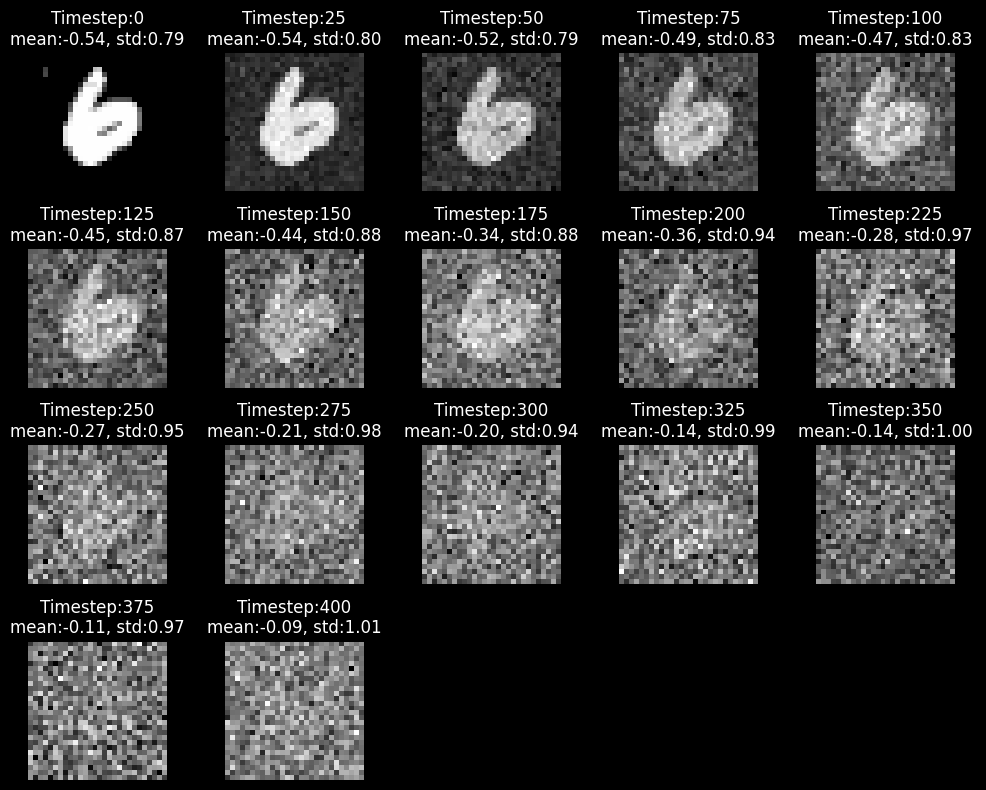

In [6]:
eg = next(iter(DataLoader(trainset).iter_batches(1)))

def show_diffusion():
    # Determine the timesteps at which to display the images
    timesteps = list(range(0, config.num_timesteps + 1, 25))

    # Determine number of rows and columns for the grid
    n_cols = 5  # Set the number of columns you want
    n_rows = math.ceil(len(timesteps) / n_cols)

    # Create subplots based on the number of images to display
    plt.style.use('dark_background')  
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))

    # Flatten axes array for easy indexing if n_rows > 1
    axes = axes.flatten() if n_rows > 1 else [axes]

    for idx, (i, ax) in enumerate(zip(timesteps, axes)):
        noisy_image, noise = DiffusionUtils(config).noisy_it(eg[0], jnp.array([i]), key=jrand.PRNGKey(i*100+1))
        plt_image = noisy_image["noisy_images"].squeeze()
        
        # Display image in the subplot
        ax.imshow(plt_image, cmap="gray")
        ax.set_title(f"Timestep:{i}\nmean:{plt_image.mean().item():.2f}, std:{plt_image.std().item():.2f}")
        ax.axis('off')  # Hide axis labels

    # Turn off any unused subplots
    for j in range(len(timesteps), len(axes)):
        axes[j].axis('off')

    # Adjust layout to avoid overlap
    plt.tight_layout()
    plt.show()

show_diffusion()

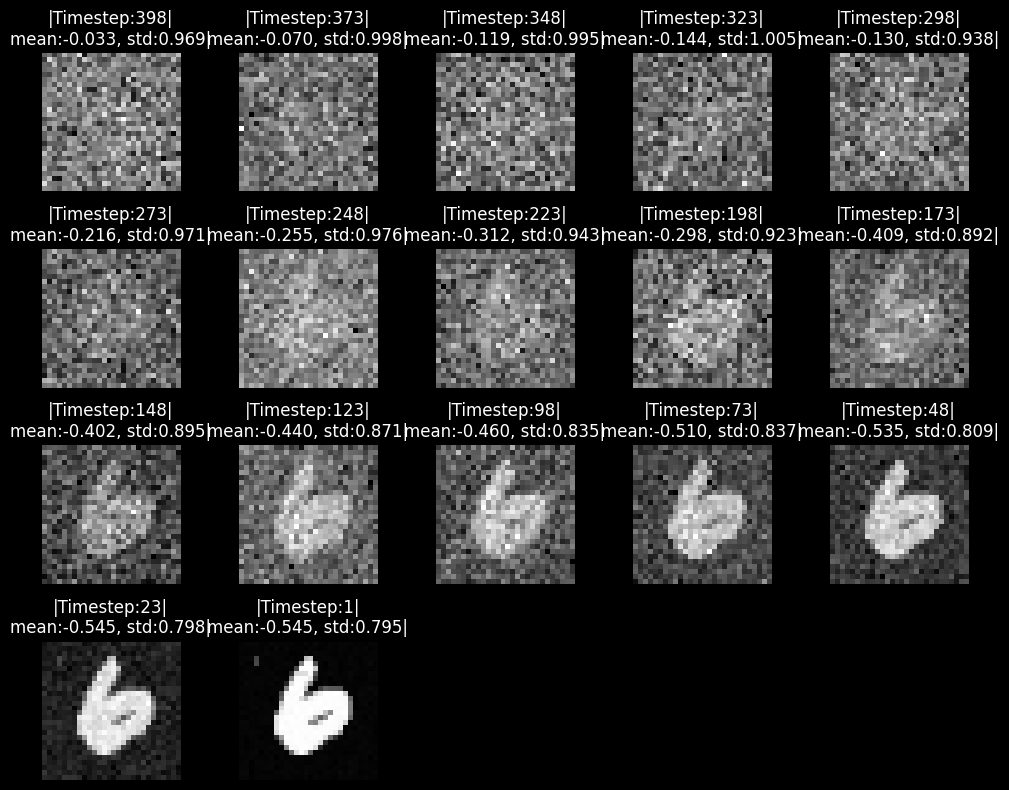

In [7]:
# test `generate` (using noisy_images, noise and timesteps)
def show_generation_from_noise():
    noisy_images, noises, times = [], [], {}
    for idx, i in enumerate(range(0, config.num_timesteps-1)):
        noisy_image, noise = DiffusionUtils(config).noisy_it(eg[0], jnp.array([i]), key=jrand.PRNGKey(i*101+1))
        noisy_images.append(noisy_image["noisy_images"].squeeze())
        noises.append(noise.squeeze())
        times[idx] = i

    # Filter the timesteps for which images will be displayed
    plot_indices = [i for i, t in enumerate(list(reversed(times))[:-1]) if i % 25 == 0 or i == len(times) - 2]

    # Determine number of rows and columns for the grid
    n_cols = 5  # Set the number of columns you want
    n_rows = math.ceil(len(plot_indices) / n_cols)

    # Create subplots based on the number of images to display
    plt.style.use('dark_background')
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))

    # Flatten axes array for easy indexing if n_rows > 1
    axes = axes.flatten() if n_rows > 1 else [axes]

    for i, ax in zip(plot_indices, axes):
        t = list(reversed(times))[:-1][i]
        img = DiffusionUtils(config).one_step_ddpm(xt=noisy_images[t], pred_noise=noises[t], t=t, key=jrand.PRNGKey(t*102+10000))
        
        # Display image in the subplot
        ax.imshow(img.squeeze(), cmap="gray")
        ax.set_title(f"|Timestep:{t}\nmean:{img.mean().item():.3f}, std:{img.std().item():.3f}|".replace("\n", "|\n"))
        ax.axis('off')  # Hide axis labels

    # Turn off any unused subplots
    for j in range(len(plot_indices), len(axes)):
        axes[j].axis('off')

    # Adjust layout to avoid overlap
    plt.tight_layout()
    plt.show()

show_generation_from_noise()

# Model

## Positional and Time Embeddings

* 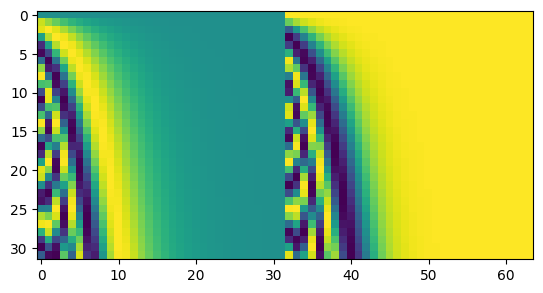

In [8]:
class TimeEmbedding(nn.Layer):
    def __init__(self, config:config, dim:int):
        super().__init__()
        self.mlp = nn.Sequential([
            nn.layers.Dense(config.d_model, kernel_initializer=config.timestep_mlp_init, bias_initializer=config.bias_init),
            nn.layers.Activation(jax.nn.selu),
            nn.layers.Dense(config.d_model, kernel_initializer=config.timestep_mlp_init, bias_initializer=config.bias_init),
        ])
        self.half_dim = dim // 2

    def sinusoidal_embeddings(self, x:Array):
        """Jax version of https://github.com/openai/glide-text2im/blob/main/glide_text2im/nn.py"""
        embeddings = jnp.exp(-math.log(10000) * jnp.arange(0, self.half_dim) / self.half_dim)
        embeddings = x[:, None] * embeddings[None]
        # in link implementation, concat(cos, sin, -1) is done
        embeddings = jnp.concatenate([jnp.cos(embeddings), jnp.sin(embeddings)], -1)
        return embeddings

    def call(self, x:Array): # (B,)
        x = self.sinusoidal_embeddings(x) # (B,) => (B, dim)
        x = self.mlp(x) # (B, d_model)
        return x # (B, d_model)

In [9]:
class PositionalEmbedding:
    def __init__(self, maxlen:int, dim:int):
        p, i = jnp.meshgrid(jnp.arange(float(maxlen)), jnp.arange(dim/2)*2)
        theta = (p/1e4**(i/dim)).T

        self.pos_emb = jnp.stack([jnp.sin(theta), jnp.cos(theta)], axis=-1)
        self.pos_emb = self.pos_emb.reshape((maxlen, dim))[None] # (1, maxlen, dim)

    def sinusoidal_embeddings(self):
        return self.pos_emb # (1, maxlen, dim)

## Attention

In [11]:
class Attention(nn.Layer):
    """```
    Multi-head Attention
    Args:
        causal:bool
        config
    Input:
        x: shape(B, N, d_model)
        training: bool
    Output:N
        linear_att_out: shape(B, N, d_model)
    ```"""
    def __init__(
            self,
            causal:bool,
            config:config,
            **kwargs
    ):
        super().__init__(**kwargs)
        assert config.d_model % config.num_heads == 0
        self.flash = config.use_flash_att
        self.causal = causal
        self.num_heads = config.num_heads
        self.dim = config.d_model//config.num_heads
        
        self.wq = nn.layers.Dense(config.d_model, use_bias=False, kernel_initializer=config.linear_init)
        self.wk = nn.layers.Dense(config.d_model, use_bias=False, kernel_initializer=config.linear_init)
        self.wv = nn.layers.Dense(config.d_model, use_bias=False, kernel_initializer=config.linear_init)
        self.dropout = nn.layers.Dropout(config.dropout_rate)

        self.wo = nn.layers.Dense(config.d_model, kernel_initializer=config.linear_init, bias_initializer=config.bias_init)
        if causal and (not config.use_flash_att): # when causal and not using flash att
            self.causal_mask = jnp.triu(jnp.full(shape=(1, 1, config.maxlen, config.maxlen), fill_value=-jnp.inf), k=1)

    def call(
            self,
            x:Array, # (B, T, d_model)
            training:bool
    ):
        B, T, d_model = x.shape

        # compute q, k, v
        q = self.wq(x) # (B, T, d_model)
        k = self.wk(x) # (B, T, d_model)
        v = self.wv(x) # (B, T, d_model)

        # compute attention weights
        if self.flash:
            shape = (B, T, self.num_heads, self.dim)
            q, k, v = (
                q.reshape(shape).astype(jnp.bfloat16),
                k.reshape(shape).astype(jnp.bfloat16),
                v.reshape(shape).astype(jnp.bfloat16)
            ) # (B, T, h, dim)
            att_out = flash_mha(q, k, v, softmax_scale=None, is_causal=self.causal).astype(jnp.float32) # (B, T, h, dim)
        else:
            shape = (B, self.num_heads, T, self.dim)
            q, k, v = q.reshape(shape), k.reshape(shape), v.reshape(shape) # (B, h, T, dim)
            att_wei = (q @ jnp.matrix_transpose(k))/self.dim**0.5 # (B, h, T, T) <= (B, h, T, dim) @ (B, h, T, dim).transpose(-1, -2)
            # causal mask
            if self.causal:
                att_wei += self.causal_mask[:, :, :T, :T] # (B, h, T, T)
            att_wei = jax.nn.softmax(att_wei, axis=-1) # (B, h, T, T)
            # apply attention weights to v
            att_out = att_wei @ v # (B, h, T, T) @ (B, h, T, dv) => (B, h, T, dv)

        # combine heads
        att_out = att_out.reshape((B, T, d_model)) # (B, T, h*dim) ==> (B, T, d_model)

        # linear of att_out
        linear_att_out = self.wo(att_out)
        linear_att_out = self.dropout(linear_att_out, training=training) # (B, T, d_model)
        return linear_att_out

## FFN

In [13]:
class FFN(nn.Layer):
    """https://github.com/huggingface/pytorch-image-models/blob/main/timm/layers/mlp.py#L13"""
    def __init__(self, config:config):
        super().__init__()
        hidden_dim = config.d_model*4
        self.layers = nn.Sequential([
            nn.layers.Dense(hidden_dim, kernel_initializer=config.linear_init, bias_initializer=config.bias_init),
            nn.layers.Activation(lambda x: jax.nn.gelu(x, approximate=True)),
            nn.layers.Dropout(config.dropout_rate),
            nn.layers.Dense(config.d_model, kernel_initializer=config.linear_init, bias_initializer=config.bias_init),
            nn.layers.Dropout(config.dropout_rate)
        ])

    def call(self, x:Array, training:bool):
        return self.layers(x, training=training)

## Patch Ops

In [15]:
class PatchOps:
    """See https://github.com/huggingface/pytorch-image-models/blob/main/timm/layers/patch_embed.py#L112"""
    def __init__(self, config:config, project_patches:bool=True):
        self.proj = project_patches
        self.p = config.patch_size
        if project_patches:
            self.patch_proj = nn.layers.Dense(
                config.d_model, 
                kernel_initializer=config.linear_init,
                bias_initializer=config.bias_init
            )
        self.H, self.W = config.H, config.W
        self.c = config.out_channels

    def patchify(self, images:Array):
        B, H, W, C = images.shape
        patches = nn.ops.image.extract_patches(images, size=self.p) # (B, H, W, C)
        patches = patches.reshape(
            B,
            (H // self.p) * (W // self.p), # N = (H*W)/P**2
            self.p * self.p * C, # dim = P*2 * C
        ) # (B, N, dim)
        if self.proj:
            patches = self.patch_proj(patches) # (B, N, embed_dim)
        return patches # (B, N = (H*W)/P**2, embed_dim or dim)
    
    def unpacthify(self, x:Array): # (B, N = H*W//P**2, D = (P**2)*C)
        h, w = self.H//self.p, self.W//self.p # int(x.shape[1]**0.5) # h = H//P
        x = x.reshape(-1, h, w, self.p, self.p, self.c) # (B, H//P, W//P, P, P, C)
        x = jnp.einsum('bhwpqc->bhpwqc', x) # (B, H//P, P, W//P, P, C)
        x = x.reshape(-1, h*self.p, w*self.p, self.c) # (B, H, W, C)
        return x

```python
def visualize_patches(x:Array, patch_size:int):
    test_patch = PatchOps(config(d_model=1, patch_size=patch_size), project_patches=False)
    patches:Array = np.array(test_patch.patchify(x.astype(np.float32))).astype(np.float32)
    n = int(jnp.sqrt(patches.shape[1]))
    plt.figure(figsize=(5,5))
    for i, patch in enumerate(patches[0]):
        ax = plt.subplot(n, n, i + 1)
        patch_img = np.reshape(patch, (patch_size, patch_size, 1))
        plt.imshow(patch_img, cmap="gray")
        plt.axis("off")

visualize_patches(scale(X_train[:1]), 2)
```
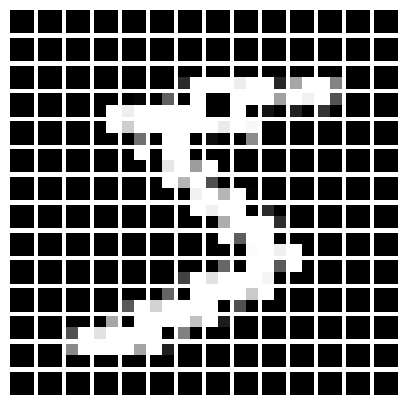

```python
patchy = PatchOps(config, project_patches=False)
plt.imshow(
    descale(patchy.unpacthify(patchy.patchify(scale(X_train[:1]))))[0],
    cmap="gray"
)
plt.show()
del patchy
```
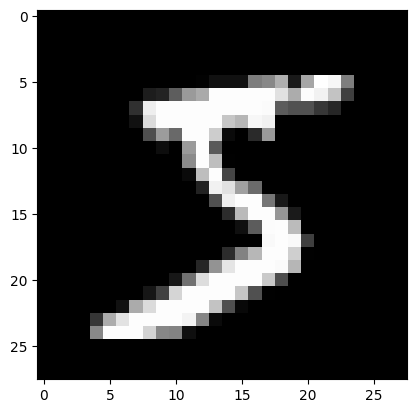

## Label Embeddings

In [17]:
class LabelEmbedding(nn.Layer):
    def __init__(self, config:config):
        super().__init__()
        self.use_cfg = config.cfg_dropout_rate > 0
        self.label_embed = nn.layers.Embedding(
            input_dim=config.num_classes + int(self.use_cfg),
            output_dim=config.d_model,
            embeddings_initializer=config.label_emb_init
        )
        self.cfg_dropout_rate = config.cfg_dropout_rate
        self.num_classes = config.num_classes
    
    def drop_labels(self, labels:Array, key:Array):
        ids_to_drop = jrand.uniform(key, shape=(labels.shape[0],)) < self.cfg_dropout_rate
        labels = jnp.where(ids_to_drop, self.num_classes, labels)
        return labels

    def call(self, labels:Array, key:Array, training:bool):
        if self.use_cfg and training:
            labels = self.drop_labels(labels, key)
        return self.label_embed(labels, training=training)

## DiT Block and Comps

In [19]:
def shift_scale(x:Array, gamma:Array, beta:Array):
    """ https://github.com/facebookresearch/DiT/blob/main/models.py#L19
    ```
    def modulate(x, shift, scale):
        return x * (1 + scale.unsqueeze(1)) + shift.unsqueeze(1)
    ```
    why +1 while scaling?
    """
    return x*(1 + gamma) + beta

In [20]:
class Block(nn.Layer):
    def __init__(self, config:config):
        super().__init__()
        self.scale_shift_scale = nn.Sequential([
            nn.layers.Activation(jax.nn.silu),
            nn.layers.Dense(config.d_model*6, kernel_initializer=config.adaLN_linear_bias_init, bias_initializer=config.adaLN_linear_bias_init),
        ])
        self.norm1 = nn.layers.LayerNormalization(epsilon=1e-6, center=False, scale=False)
        self.att = Attention(causal=False, config=config)

        self.norm2 = nn.layers.LayerNormalization(epsilon=1e-6, center=False, scale=False)
        self.pointwise_ffn = FFN(config)

    def call(self, x:Array, cond:Array, training:bool): # x: (B, T, d_model), cond: (B, d_model)
        gamma1, beta1, alpha1, gamma2, beta2, alpha2 = jnp.array_split(self.scale_shift_scale(cond)[:, None], 6, axis=-1) # 6*(B, 1, d_model) <= (B, 1, 6*d_model) <= (B, d_model)
        x = x + alpha1*self.att(shift_scale(self.norm1(x), gamma1, beta1), training=training) # (B, T, d_model)
        x = x + alpha2*self.pointwise_ffn(shift_scale(self.norm2(x), gamma2, beta2), training=training) # (B, T, d_model)
        return x # (B, T, d_model)

In [22]:
class NormLinear(nn.Layer):
    def __init__(self, config:config):
        super().__init__()
        self.shift_scale = nn.Sequential([
            nn.layers.Activation(jax.nn.silu),
            nn.layers.Dense(config.d_model*2, kernel_initializer=config.adaLN_linear_bias_init, bias_initializer=config.adaLN_linear_bias_init),
        ])
        self.norm = nn.layers.LayerNormalization(epsilon=1e-6, center=False, scale=False)
        self.linear = nn.layers.Dense((config.patch_size**2)*config.out_channels, kernel_initializer=config.final_layer_linear_bias_init, bias_initializer=config.final_layer_linear_bias_init)

    def call(self, x:Array, c:Array): # (B, T, D), # (B, D)
        gamma, beta = jnp.array_split(self.shift_scale(c)[:, None], 2, axis=-1) # (B, 1, D) <= (B, 1, 2*D) <= (B, D)
        x = shift_scale(self.norm(x), gamma, beta)
        x = self.linear(x)
        return x # (B, T, (P**2)*C)

## DiT

In [24]:
class DiT(nn.Model):
    def __init__(self, config:config):
        super().__init__()
        self.patch_ops = PatchOps(config)
        self.positional_embeddings = PositionalEmbedding(config.maxlen, config.d_model).sinusoidal_embeddings() # (1, maxlen, d_model)
        self.time_embed = TimeEmbedding(config, dim=config.d_model//2)
        self.label_embed = LabelEmbedding(config)
        self.blocks = [Block(config) for _ in range(config.num_layers)]
        self.norm_linear = NormLinear(config)

    def call(
        self,
        x:Array, # (B, H, W, C = 3 or 1)
        t:Array, # (B,)
        y:tp.Optional[Array], # (B,)
        key:tp.Optional[Array],
        training:bool
    ):
        x = self.patch_ops.patchify(x) # (B, N = H*W//P**2, d_model)
        x += self.positional_embeddings

        cond = self.time_embed(t, training=training) # (B, d_model)
        if y is not None:
            cond += self.label_embed(y, key, training=training) # (B, d_model)
        
        for block in self.blocks:
            x = block(x, cond, training=training) # (B, N, d_model)
        
        x = self.norm_linear(x, cond) # (B, N = H*W//P**2, D = (P**2)*C)
        x = self.patch_ops.unpacthify(x) # (B, H, W, C)
        return x

# Train Utils

In [25]:
def build_model(model:nn.Model, input_shape:tuple, label_intervals:tuple[int, int]):
    blabla = model(
        jrand.normal(jrand.PRNGKey(342212), input_shape),
        jnp.arange(input_shape[0]), 
        jrand.randint(jrand.PRNGKey(32344), shape=(input_shape[0],), minval=label_intervals[0], maxval=label_intervals[-1]), 
        jrand.PRNGKey(342212),
        training=True
    )
    assert (blabla == 0).all()
    assert (blabla.shape 
            == (input_shape[0], config.H, config.W, config.out_channels))
    return model

In [26]:
def save_object(dir_suffix_ftype:str, obj:tp.Any):
    """
    dir_suffix_ftype: directory suffix and file type separated by "|"\n
    obj: Anything which is to be stored
    """
    dir, suffix, ftype = dir_suffix_ftype.split("|"); path = os.path.join(dir, "".join([suffix, f".{ftype}"]))
    os.makedirs(name=dir, exist_ok=True)
    with open(path, "wb") as file:
        pickle.dump(obj=obj, file=file, protocol=pickle.HIGHEST_PROTOCOL)
    return path

def load_object(path:str):
    with open(path, "rb") as file:
        obj = pickle.load(file)
    return obj

# Training

In [27]:
train_iterator = iter(DataLoader(trainset).iter_batches(config.batch_size))
val_iterator = iter(DataLoader(valset).iter_batches(config.batch_size))

In [28]:
model = build_model(
    model=DiT(config),
    input_shape=(2, config.H, config.W, config.in_channels),
    label_intervals=(0, 10)
)
model.summary()

Model: "di_t"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ time_embedding (TimeEmbedding)  │ ?                         │    124,992 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ label_embedding                 │ ?                         │      2,880 │
│ (LabelEmbedding)                │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block (Block)                   │ ?                         │  1,496,448 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block_1 (Block)                 │ ?                         │  1,496,448 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block_2 (Block)                 │ ?                         │  1,496,448 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block_3 (Block)                 │ ?                         │  1,496,448 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block_4 (Block)                 │ ?                         │  1,496,448 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block_5 (Block)                 │ ?                         │  1,496,448 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ norm_linear (NormLinear)        │ ?                         │    167,620 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 9,274,180 (35.38 MB)

 Trainable params: 9,274,180 (35.38 MB)

 Non-trainable params: 0 (0.00 B)

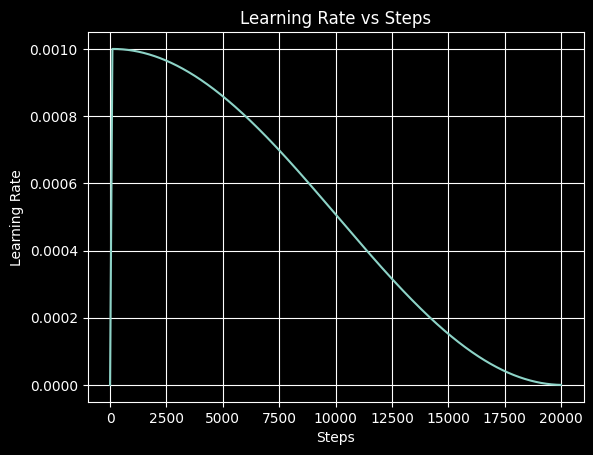

In [29]:
learning_rate = nn.optimizers.schedules.CosineDecay(
    initial_learning_rate=config.min_lr,
    decay_steps=config.decay_steps,
    warmup_steps=config.warmup_steps,
    warmup_target=config.max_lr,
    alpha=config.min_lr/config.max_lr
) if not config.no_decay else lambda _: config.max_lr

steps = jnp.arange(0, config.num_steps)
lrs = jax.vmap(learning_rate)(steps)

plt.plot(steps, lrs); del lrs, steps
plt.grid(True)
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.title("Learning Rate vs Steps")
plt.show()

In [30]:
class ParamGradManager:
    """dont decay parameters with dim less than 2"""
    def __init__(self, trainable_vars:list):
        order_before_segregate = [v.path for v in trainable_vars]
        order_after_segregate = (
            [v.path for v in trainable_vars if len(v.shape)!=1] +
            [v.path for v in trainable_vars if len(v.shape)==1]
        )
        self.idx = [order_after_segregate.index(b) for b in order_before_segregate]

    def filter_obj(self, trainable_obj:list):
        """can be grads or params"""
        decay_obj = [v for v in trainable_obj if len(v.shape)!=1]
        nodecay_obj = [v for v in trainable_obj if len(v.shape)==1]
        return decay_obj, nodecay_obj
    
    def combine_obj(self, decay_obj:list, nodecay_obj:list):
        obj = decay_obj + nodecay_obj
        return [obj[i] for i in self.idx]

In [31]:
adamw = lambda weight_decay: nn.optimizers.AdamW(
        learning_rate=learning_rate,
        beta_1=config.beta1,
        beta_2=config.beta2,
        clipnorm=config.clipnorm,
        weight_decay=weight_decay,
        # use_ema=int(config.ema!=0),
        # ema_momentum=config.ema
)
decay_optimizer = adamw(weight_decay=config.weight_decay)
nodecay_optimizer = adamw(weight_decay=0.0)
loss_fn = nn.losses.MeanSquaredError()

diff_utils = DiffusionUtils(config)

In [32]:
trainable_vars = model.trainable_variables
non_trainable_vars = model.non_trainable_variables

param_grad_manager = ParamGradManager(trainable_vars)
for param, opt in zip(param_grad_manager.filter_obj(trainable_vars), [decay_optimizer, nodecay_optimizer]):
    opt.build(param)

decay_opt_vars, nodecay_opt_vars = decay_optimizer.variables, nodecay_optimizer.variables

In [33]:
@partial(jax.jit, static_argnums=-1)
def compute_loss(
    trainable_vars:list,
    non_trainable_vars:list,
    X_batch:Array, # (B, H, W, C)
    timestep_batch:Array, # (B,)
    labels:tp.Optional[Array], # (B,)
    noise_true:Array, # (B, H, W, C)
    key:Array,
    num_grad_accumalation_steps:int
):
    noise_pred, non_trainable_vars = model.stateless_call(
        trainable_vars, non_trainable_vars, X_batch,
        timestep_batch, labels, key, True
    )
    loss = loss_fn(noise_true, noise_pred)
    loss /= num_grad_accumalation_steps
    return loss, (non_trainable_vars, noise_pred)
grad_fn = jax.value_and_grad(compute_loss, has_aux=True)

@partial(jax.jit, static_argnums=-1)
def mini_step(
    train_state:tp.Sequence[list],
    X_batch:Array, # (B, H, W, C)
    timestep_batch:Array, # (B,)
    labels:tp.Optional[Array], # (B,)
    noise_true, # (B, H, W, C)
    key:Array,
    num_grad_accumalation_steps:int
):
    trainable_vars, non_trainable_vars = train_state

    (loss, aux), grad = grad_fn(
        trainable_vars, non_trainable_vars,
        X_batch, timestep_batch, labels, noise_true,
        key, num_grad_accumalation_steps
    )
    non_trainable_vars, noise_pred = aux
    return grad, loss, (trainable_vars, non_trainable_vars), noise_pred

decay_opt_apply = jax.jit(
    fun=lambda opt_vars, grads, trainable_vars: decay_optimizer.stateless_apply(
        opt_vars, grads, trainable_vars)
)
nodecay_opt_apply = jax.jit(
    fun=lambda opt_vars, grads, trainable_vars: nodecay_optimizer.stateless_apply(
        opt_vars, grads, trainable_vars)
)

def update_params(
    grads:list,
    trainable_vars:list,
    optimizer_vars:tuple[list, list],
):
    decay_grads, nodecay_grads = param_grad_manager.filter_obj(grads)
    decay_trainable_vars, nodecay_trainable_vars = param_grad_manager.filter_obj(trainable_vars)
    decay_opt_vars, nodecay_opt_vars = optimizer_vars
    
    decay_trainable_vars, decay_opt_vars = decay_opt_apply(
        decay_opt_vars, decay_grads, decay_trainable_vars
    )
    nodecay_trainable_vars, nodecay_opt_vars = nodecay_opt_apply(
        nodecay_opt_vars, nodecay_grads, nodecay_trainable_vars
    )
    trainable_vars1 = param_grad_manager.combine_obj(decay_trainable_vars, nodecay_trainable_vars)
    assert (
        [v.shape for v in trainable_vars1] ==
        [v.shape for v in trainable_vars]), (
            f"train vars aft: {[v.shape for v in trainable_vars1]}\n\ntrain vars bef: {[v.shape for v in trainable_vars]}"
    )
    return trainable_vars1, (decay_opt_vars, nodecay_opt_vars)

def eval(key:Array):
    gen_image = diff_utils.generate(
        model=model,
        trainable_vars=trainable_vars,
        non_trainable_vars=non_trainable_vars,
        labels=[r.randint(0, config.num_classes-1)],
        key=key
    )
    plt.imshow(gen_image.squeeze(), cmap="gray")
    plt.show() # debug_input = (scale(X_train)[:2], Y_train[:2])

In [ ]:
wait = 0
step = 1
training_losses = {"train": []}
key = jrand.PRNGKey(config.seed)

t0 = time.time()
print("Training about to start...")
X_batch, labels = next(train_iterator)

while True:
    # condition to terminate
    if step > config.num_steps or wait > config.patience:
        print(f"Early Stopping at Step {step}." if wait > config.patience else "Training Ended.")
        break

    key, key2, key3, key4 = jrand.split(key, num=4)
    
    # noise it
    timesteps = jrand.randint(
        key2, (X_batch.shape[0],), minval=0, maxval=config.num_timesteps
    )
    noisy_image_timestep, noise_true = diff_utils.noisy_it(X_batch, timesteps, key3)

    # train model
    grads = jax.tree_util.tree_map(jnp.zeros_like, trainable_vars)
    for _ in range(config.num_grad_accumalation_steps):
        grad, loss, (trainable_vars, non_trainable_vars), noise_pred = mini_step(
            (trainable_vars, non_trainable_vars),
            noisy_image_timestep["noisy_images"], noisy_image_timestep["timesteps"],
            labels, noise_true, key4,
            config.num_grad_accumalation_steps
        )
        grads = jax.tree_util.tree_map(
            lambda g1, g2: jnp.add(g1, g2), grads, grad
        ) # sum grads for grad accumation
        X_batch, labels = next(train_iterator)
    grad = None # save memory

    loss = loss*config.num_grad_accumalation_steps # loss from last mini-step
    
    trainable_vars, (decay_opt_vars, nodecay_opt_vars) = update_params(
        grads, trainable_vars, (decay_opt_vars, nodecay_opt_vars)
    )
    grads = None # save memory

    if step % config.ckpt_freq == 0 or step == config.num_steps:
        eval(key)
        ckpt = (
                trainable_vars,
                non_trainable_vars,
                (decay_opt_vars, nodecay_opt_vars),
                step,
            )
        
        _ = save_object(
            config.checkpoint_dir+f"|checkpoint|diffusion_transformer",
            obj=ckpt
        )
        print(f"Saved checkpoint of step {step}.")


    # time
    t1 = time.time()
    dt = t1-t0; t0 = t1

    # print the essentials
    print(
        f"| Step: {step} || Loss: {loss:.4f} |"
        f"| LR: {learning_rate(step):e} || dt: {dt*1000:.2f}ms |"
    )
    training_losses["train"].append(loss.tolist())
    step += 1

train_state = (trainable_vars, non_trainable_vars)
save_object(
    config.checkpoint_dir+f"|mnist_train_state|diffusion_transformer",
    obj=train_state
) # clear logs very long...

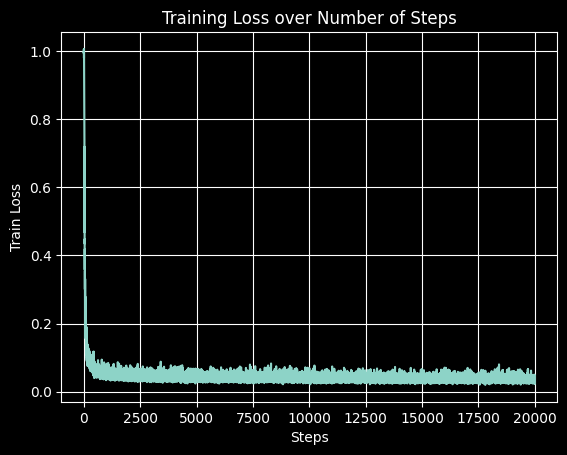

In [35]:
plt.plot(training_losses["train"])
plt.title("Training Loss over Number of Steps")
plt.xlabel("Steps")
plt.ylabel("Train Loss")
plt.grid(True)
plt.show()

# Inference

Generating images of [0]


100%|██████████| 399/399 [00:12<00:00, 31.14it/s]


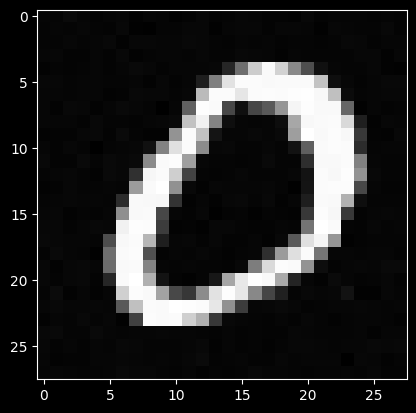

Generating images of [1]


100%|██████████| 399/399 [00:12<00:00, 31.71it/s]


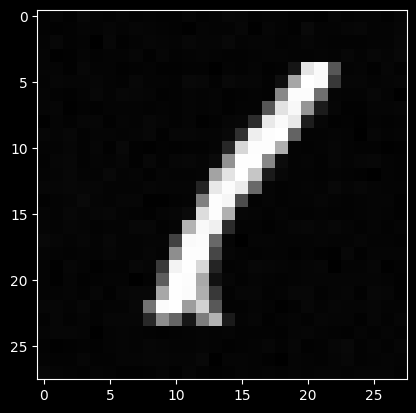

Generating images of [2]


100%|██████████| 399/399 [00:13<00:00, 30.35it/s]


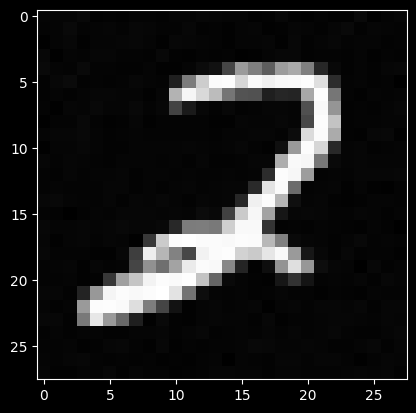

Generating images of [3]


100%|██████████| 399/399 [00:12<00:00, 31.25it/s]


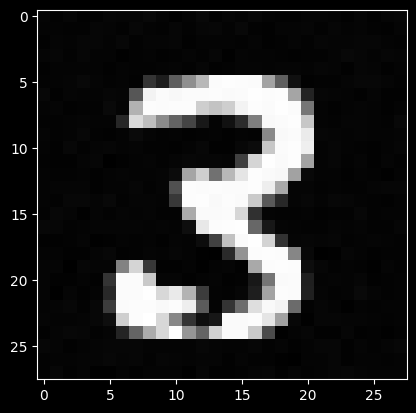

Generating images of [4]


100%|██████████| 399/399 [00:12<00:00, 31.28it/s]


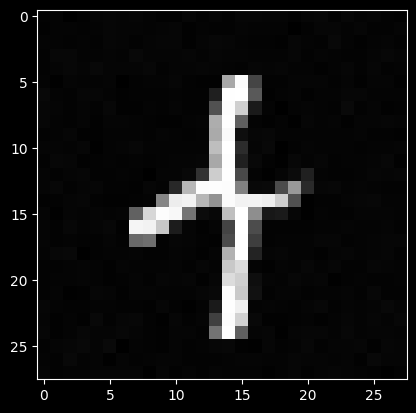

Generating images of [5]


100%|██████████| 399/399 [00:12<00:00, 31.42it/s]


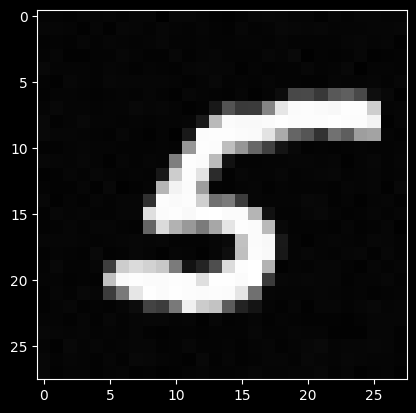

Generating images of [6]


100%|██████████| 399/399 [00:13<00:00, 30.61it/s]


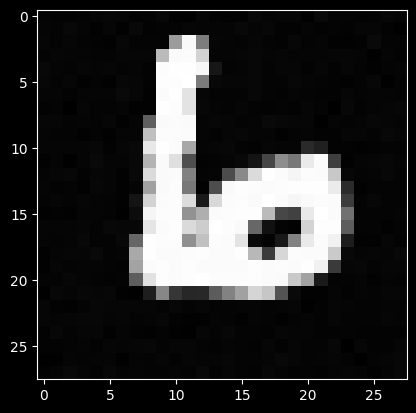

Generating images of [7]


100%|██████████| 399/399 [00:12<00:00, 30.78it/s]


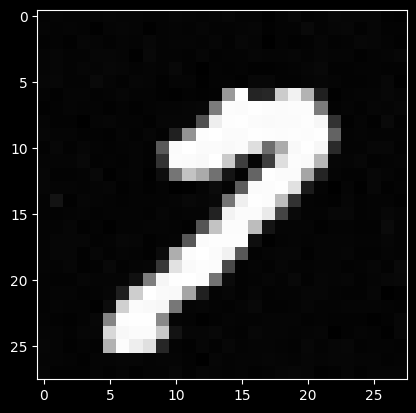

Generating images of [8]


100%|██████████| 399/399 [00:12<00:00, 31.35it/s]


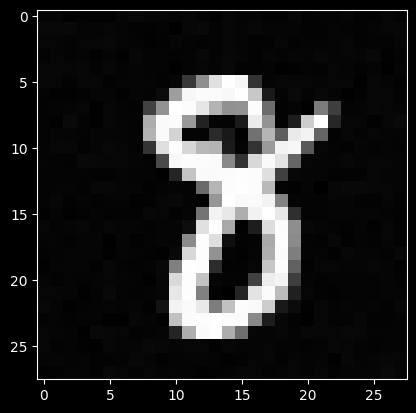

Generating images of [9]


100%|██████████| 399/399 [00:12<00:00, 31.40it/s]


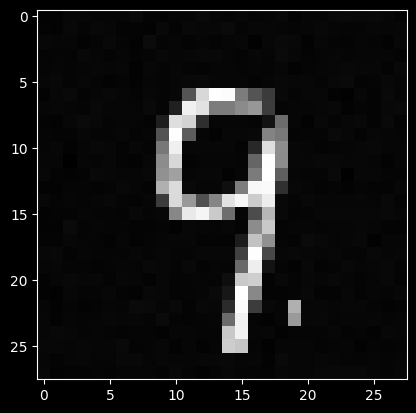

In [36]:
for i in range(10):
    key, subkey = jrand.split(key)
    gen_image = diff_utils.generate(
        model=model, num_samples=1, labels=[i], 
        trainable_vars=trainable_vars, non_trainable_vars=non_trainable_vars, 
        key=subkey
    )
    plt.imshow(gen_image.squeeze(), cmap="gray")
    plt.show()